# ENSAE - Fairness in ML Project

First, I try to understand the AUC based fairness constraints:

Plotting these conditions directly as they are described in mathematical terms in the paper might not be straightforward without specific data or defined score distributions. However, you can visualize the concept by simulating data. Here’s a conceptual way to plot scenarios that might satisfy or violate these fairness constraints:

**Simulate Score Distributions:** Assume two groups with scores normally distributed but with different means and variances. Simulate these scores using Python.

**Calculate and Plot ROC Curves:** Use these scores to calculate and plot ROC curves for each group.

**Calculate AUCs:** Compute the AUC for these curves and visually inspect if they are similar (indicating fairness) or different.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

In [2]:
# load the data to a pandas dataset
df = pd.read_csv("data/compas-scores-two-years.csv")
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [3]:
# Define the columns of interest and filter the df according to them

# vr = violent recidivism
    # r = recidivism
    # Types of crimes in the USA: felonies and misdemeanors
interesting_cols = [  # 'compas_screening_date',
    'sex',  # 'dob',
    'age', 'race',
    'juv_fel_count', 'decile_score', 'juv_misd_count',
    'juv_other_count', 'priors_count',
    'days_b_screening_arrest',
    'c_jail_in', 'c_jail_out',
    # 'c_offense_date', 'c_arrest_date',
    # 'c_days_from_compas',
    'c_charge_degree',
    # 'c_charge_desc',
    'is_recid',
    # 'r_charge_degree',
    # 'r_days_from_arrest', 'r_offense_date',  # 'r_charge_desc',
    # 'r_jail_in', 'r_jail_out',
    # 'is_violent_recid', 'num_vr_cases',  # 'vr_case_number',
    # 'vr_charge_degree', 'vr_offense_date',
    # 'vr_charge_desc', 'v_type_of_assessment',
    'v_decile_score',  # 'v_score_text',
    # 'v_screening_date',
    # 'type_of_assessment',
    'decile_score.1',  # 'score_text',
    # 'screening_date'
    ]

df = df[interesting_cols]

# Set pandas display options to show the full content of each field
pd.set_option('display.max_colwidth', None)

df.head()

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_charge_degree,is_recid,v_decile_score,decile_score.1
0,Male,69,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,F,0,1,1
1,Male,34,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,F,1,1,3
2,Male,24,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,F,1,3,4
3,Male,23,African-American,0,8,1,0,1,NaN,NaN,NaN,F,0,6,8
4,Male,43,Other,0,1,0,0,2,NaN,NaN,NaN,F,0,1,1


In [4]:
# Keep rows where the screening happened within 30 days before or after the arrest
df = df[(df["days_b_screening_arrest"] >= -30) & (df["days_b_screening_arrest"] <= 30)]

# Calculate the number of days each individual was in jail
df["days_in_jail"] = (pd.to_datetime(df["c_jail_out"]) - pd.to_datetime(df["c_jail_in"])).dt.days

# Filter out rows where recidivism data is not available or the charge degree is 'Other'
df = df[(df["is_recid"] >= 0) & (df["c_charge_degree"] != "O")]

# Prepare data for encoding and machine learning
cols_to_delete = ["c_jail_out", "c_jail_in", "days_b_screening_arrest"]
df = df[[a for a in df.columns if a not in cols_to_delete]]

df.head()

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_recid,v_decile_score,decile_score.1,days_in_jail
0,Male,69,Other,0,1,0,0,0,F,0,1,1,0
1,Male,34,African-American,0,3,0,0,0,F,1,1,3,10
2,Male,24,African-American,0,4,0,1,4,F,1,3,4,1
5,Male,44,Other,0,1,0,0,0,M,0,1,1,1
6,Male,41,Caucasian,0,6,0,0,14,F,1,2,6,6


In [5]:
# Define quantitative and qualitative columns for preprocessing
col_quanti = ["age", "juv_fel_count", "decile_score", "juv_misd_count", "priors_count",
              "v_decile_score", "decile_score.1", "days_in_jail"]
col_quali = ["race", "c_charge_degree"]

# Extract and transform qualitative (categorical) features using pandas.get_dummies
X_quali = pd.get_dummies(df[col_quali])

# Combine quantitative and qualitative data
X_quanti = df[col_quanti]
df_preprocessed = pd.concat([X_quanti, X_quali], axis=1)

# Define the target variable (recidivism) and convert it to -1, 1 format
df_preprocessed['Y'] = 2 * df['is_recid'] - 1

# Define the sensitive attribute (race) as binary for 'African-American'
df_preprocessed['Z'] = (df['race'] == 'African-American').astype(int)

df_preprocessed.head()

,age,juv_fel_count,decile_score,juv_misd_count,priors_count,v_decile_score,decile_score.1,days_in_jail,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,Y,Z
0,69,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,-1,0
1,34,0,3,0,0,1,3,10,1,0,0,0,0,0,1,0,1,1
2,24,0,4,0,4,3,4,1,1,0,0,0,0,0,1,0,1,1
5,44,0,1,0,0,1,1,1,0,0,0,0,0,1,0,1,-1,0
6,41,0,6,0,14,2,6,6,0,0,1,0,0,0,1,0,1,0


In [6]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the quantitative columns
df_preprocessed[col_quanti] = scaler.fit_transform(df_preprocessed[col_quanti])

df_preprocessed.head()

,age,juv_fel_count,decile_score,juv_misd_count,priors_count,v_decile_score,decile_score.1,days_in_jail,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,Y,Z
0,0.653846,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00125,0,0,0,0,0,1,1,0,-1,0
1,0.205128,0.0,0.222222,0.0,0.000000,0.000000,0.222222,0.01375,1,0,0,0,0,0,1,0,1,1
2,0.076923,0.0,0.333333,0.0,0.105263,0.222222,0.333333,0.00250,1,0,0,0,0,0,1,0,1,1
5,0.333333,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00250,0,0,0,0,0,1,0,1,-1,0
6,0.294872,0.0,0.555556,0.0,0.368421,0.111111,0.555556,0.00875,0,0,1,0,0,0,1,0,1,0


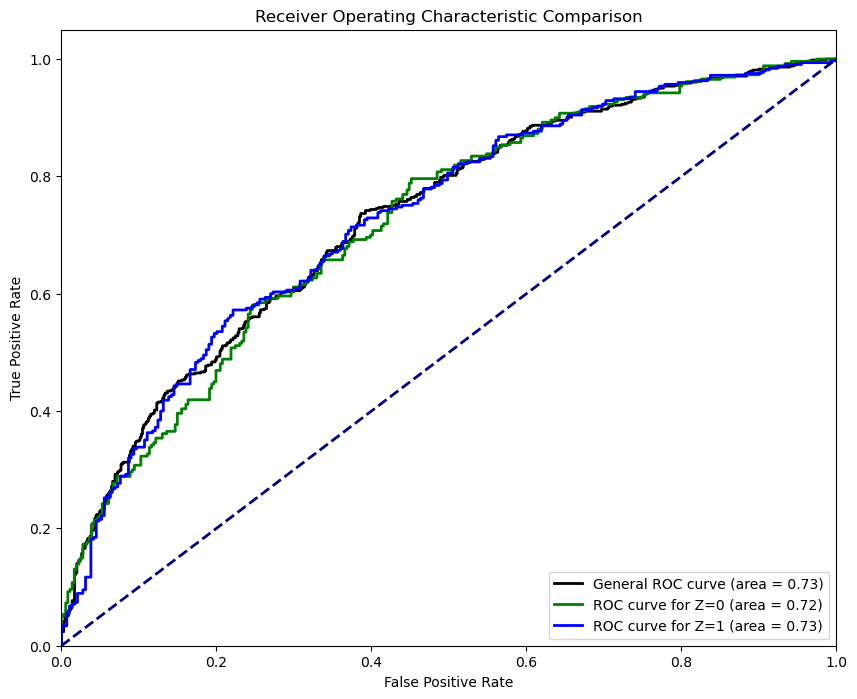

In [7]:
# Split data into features and target
X = df_preprocessed.drop(['Y', 'Z'], axis=1)
y = df_preprocessed['Y']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for all data
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='black',
         lw=lw, label='General ROC curve (area = %0.2f)' % roc_auc)

# For ROC curves by group (e.g., Z=0 and Z=1)
colors = ['green', 'blue']
for idx, z_val in enumerate([0, 1]):
    X_test_z = X_test[df_preprocessed.loc[X_test.index, 'Z'] == z_val]
    y_test_z = y_test[df_preprocessed.loc[X_test.index, 'Z'] == z_val]
    y_probs_z = model.predict_proba(X_test_z)[:, 1]
    
    fpr_z, tpr_z, _ = roc_curve(y_test_z, y_probs_z)
    roc_auc_z = auc(fpr_z, tpr_z)
    
    # Plot ROC curve for each subgroup
    plt.plot(fpr_z, tpr_z, color=colors[idx],
             lw=lw, label='ROC curve for Z={} (area = {:.2f})'.format(z_val, roc_auc_z))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Comparison')
plt.legend(loc="lower right")
plt.show()

Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


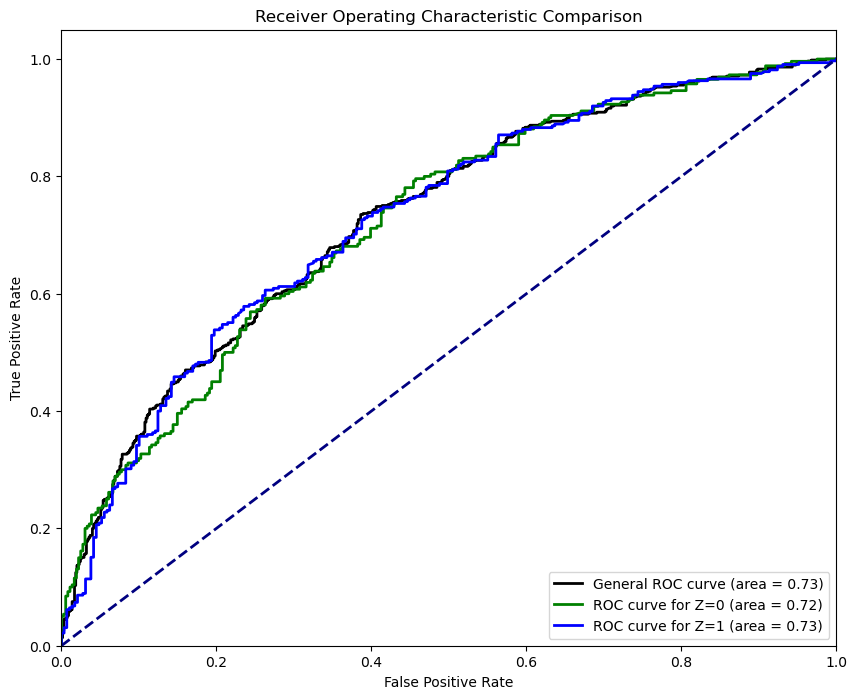

In [8]:
# Split data into features and target
X = df_preprocessed.drop(['Y','Z'], axis=1)
y = df_preprocessed['Y']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setup GridSearchCV to find the best parameters for Logistic Regression
parameters = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'saga' could also be used but is generally slower
}
grid_search = GridSearchCV(LogisticRegression(), parameters, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters:", grid_search.best_params_)

# Initialize and train the logistic regression model
best_params = grid_search.best_params_
model = LogisticRegression(**best_params)
model.fit(X_train, y_train)

# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for all data
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='black',
         lw=lw, label='General ROC curve (area = %0.2f)' % roc_auc)

# For ROC curves by group (e.g., Z=0 and Z=1)
colors = ['green', 'blue']
for idx, z_val in enumerate([0, 1]):
    X_test_z = X_test[df_preprocessed.loc[X_test.index, 'Z'] == z_val]
    y_test_z = y_test[df_preprocessed.loc[X_test.index, 'Z'] == z_val]
    y_probs_z = model.predict_proba(X_test_z)[:, 1]
    
    fpr_z, tpr_z, _ = roc_curve(y_test_z, y_probs_z)
    roc_auc_z = auc(fpr_z, tpr_z)
    
    # Plot ROC curve for each subgroup
    plt.plot(fpr_z, tpr_z, color=colors[idx],
             lw=lw, label='ROC curve for Z={} (area = {:.2f})'.format(z_val, roc_auc_z))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Comparison')
plt.legend(loc="lower right")
plt.show()

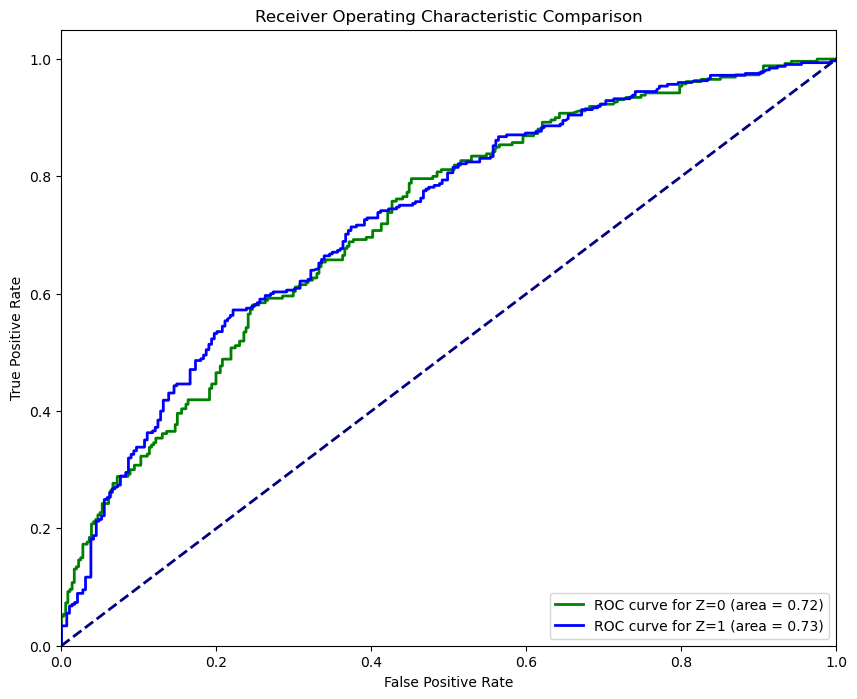

In [9]:
# Split data into features and target
X = df_preprocessed.drop(['Y', 'Z'], axis=1)
y = df_preprocessed['Y']
Z = df_preprocessed['Z']

# Split data into training and testing sets
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.2, random_state=42)

# Initialize the logistic regression model
model = LogisticRegression(solver='liblinear')  # Using liblinear as it works well with binary classification
model.fit(X_train, y_train)

# Colors for each subgroup
colors = ['green', 'blue']
lw = 2  # Line width for plotting

# Plot ROC curve for each subgroup
plt.figure(figsize=(10, 8))
for idx, z_val in enumerate([0, 1]):
    # Filter test set based on Z
    indices = Z_test == z_val
    X_test_z = X_test[indices]
    y_test_z = y_test[indices]

    # Predict probabilities on the test set for current subgroup
    y_probs_z = model.predict_proba(X_test_z)[:, 1]

    # Compute ROC curve and ROC AUC
    fpr_z, tpr_z, _ = roc_curve(y_test_z, y_probs_z)
    roc_auc_z = auc(fpr_z, tpr_z)

    # Plot ROC curve for the subgroup
    plt.plot(fpr_z, tpr_z, color=colors[idx],
             lw=lw, label=f'ROC curve for Z={z_val} (area = {roc_auc_z:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Comparison')
plt.legend(loc="lower right")
plt.show()